# 📘 Project: Face Mask Detection

Description: End-to-end deep learning project for detecting whether a person is wearing a face mask or not. The project includes data preprocessing, model training with CNNs, evaluation using accuracy, F1-score, and confusion matrix, and allows testing on individual images.

Problem Definition and Data Collection

Objective: Build a binary classification model to detect whether a person is wearing a face mask or not wearing a mask.

Dataset Structure: The dataset contains images of size 224x224, organized into two main folders: train (for training) and test (for evaluation). Each folder has subfolders corresponding to the classes: Mask and No_Mask.

## Imports and Config

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
import cv2

INIT_LR = 1e-4
EPOCHS = 10
BS = 32
DIRECTORY = r"C:\Users\DELL\Desktop\archive (3)\data"
CATEGORIES = ["with_mask", "without_mask"]
IMG_SIZE = 224


## Load Images

In [ ]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        data.append(image)
        labels.append(category)

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


## Data Augmentation

In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


## Build Mode
Build Model: MobileNetV2 pretrained on ImageNet is used as the base (without the top layers), with a custom head added consisting of AveragePooling, Flatten, Dense(128, ReLU), Dropout(0.5), and Dense(2, Softmax) for Mask/No_Mask classification. Base layers are frozen to train only the head initially.

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False


## Train Model

In [9]:
best_val_acc = 0.0
history = []
model.compile(
    optimizer=Adam(learning_rate=INIT_LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    H = model.fit(
        aug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=1,
        verbose=1
    )

    train_acc = H.history['accuracy'][-1]
    val_acc = H.history['val_accuracy'][-1]

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} 🚀")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save("final_best_mask_model.h5")
        print(f"💾 Saved Best Model: {best_val_acc:.4f}")

    history.append(H)


Epoch 1/10
------------------------------
188/188 [==============================] - 122s 634ms/step - loss: 0.3057 - accuracy: 0.8879 - val_loss: 0.0829 - val_accuracy: 0.9755
Train Acc: 0.8879 | Val Acc: 0.9755 🚀
💾 Saved Best Model: 0.9755

Epoch 2/10
------------------------------
188/188 [==============================] - 121s 646ms/step - loss: 0.1189 - accuracy: 0.9631 - val_loss: 0.0557 - val_accuracy: 0.9808
Train Acc: 0.9631 | Val Acc: 0.9808 🚀
💾 Saved Best Model: 0.9808

Epoch 3/10
------------------------------
188/188 [==============================] - 175s 934ms/step - loss: 0.0897 - accuracy: 0.9722 - val_loss: 0.0476 - val_accuracy: 0.9821
Train Acc: 0.9722 | Val Acc: 0.9821 🚀
💾 Saved Best Model: 0.9821

Epoch 4/10
------------------------------
188/188 [==============================] - 163s 866ms/step - loss: 0.0752 - accuracy: 0.9742 - val_loss: 0.0420 - val_accuracy: 0.9841
Train Acc: 0.9742 | Val Acc: 0.9841 🚀
💾 Saved Best Model: 0.9841

Epoch 5/10
----------------

## Evaluate Model

Performance Matrix

[INFO] Loading model...
[INFO] Model loaded successfully.
48/48 [==============================] - 23s 428ms/step
Test Accuracy: 98.94%

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



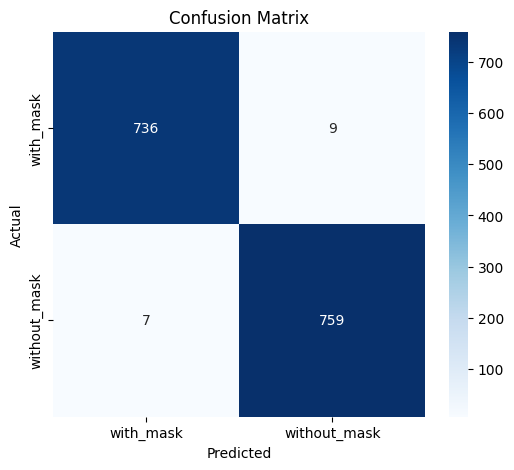

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D


class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, **kwargs):
        kwargs.pop('groups', None)  #
        super().__init__(**kwargs)



print("[INFO] Loading model...")
try:
    model = load_model("final_best_mask_model.h5", custom_objects={'DepthwiseConv2D': FixedDepthwiseConv2D})
    print("[INFO] Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise e


pred = model.predict(testX, batch_size=32)
pred_labels = np.argmax(pred, axis=1)

true_labels = np.argmax(testY, axis=1)

acc = accuracy_score(true_labels, pred_labels)
print("Test Accuracy: {:.2f}%".format(acc * 100))

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=lb.classes_))


cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lb.classes_,
            yticklabels=lb.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Face Detection

In [12]:
import cv2
import os

images_folder = "C:\\Users\\DELL\\Desktop\\stude pthon\\good"
output_folder = "C:\\Users\\DELL\\Desktop\\stude pthon\\good_detected_images"

os.makedirs(output_folder, exist_ok=True)

# Initialize the FaceDetectorYN (YuNet)
face_detector = cv2.FaceDetectorYN_create(
    model=r"C:\Users\DELL\Downloads\face_detection_yunet_2023mar.onnx",
    config="",
    input_size=(640, 640),
    score_threshold=0.6,
    nms_threshold=0.3,
    top_k=5000
)

processed_count = 0
detected_face_count = 0

for filename in os.listdir(images_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error: Image {filename} not found or corrupted.")
            continue

        h, w = img.shape[:2]
        # Update the detector input size to match the current image dimensions
        face_detector.setInputSize((w, h))

        _, faces = face_detector.detect(img)
        
        current_image_faces = 0

        if faces is not None:
            for face in faces:
                if len(face) >= 4:
                    x, y, fw, fh = face[:4].astype(int)
                    # Draw detection bounding box
                    cv2.rectangle(img, (x, y), (x + fw, y + fh), (0, 255, 0), 2)
                    current_image_faces += 1
                    detected_face_count += 1
            
            if current_image_faces > 0:
                 print(f"Detected {current_image_faces} face(s) in: {filename}")
            else:
                 print(f"No faces detected in: {filename}")

        else:
            print(f"No faces detected in: {filename}")

        # 🖼 Display the image on screen 
        cv2.imshow("Detected Faces", img)
        # 🔑 Wait for key press (500 ms) before moving to the next image
        # Press 'q' to quit early
        if cv2.waitKey(500) & 0xFF == ord('q'):
            break

        # Save the image after detection
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, img)
        processed_count += 1

# 🛑 Close all display windows
cv2.destroyAllWindows()

print("\n--- Results ---")
print(f"Total images processed: {processed_count}")
print(f"Total faces detected: {detected_face_count}")
print("Detection complete. Results saved to:", output_folder)

Detected 5 face(s) in: maksssksksss0.png
Detected 7 face(s) in: maksssksksss1.png
Detected 2 face(s) in: maksssksksss114.png
Detected 1 face(s) in: maksssksksss117.png
Detected 2 face(s) in: maksssksksss118.png
Detected 7 face(s) in: maksssksksss124.png
Detected 6 face(s) in: maksssksksss19.png
Detected 1 face(s) in: maksssksksss25.png
Detected 2 face(s) in: maksssksksss26.png
Detected 4 face(s) in: maksssksksss29.png
Detected 1 face(s) in: maksssksksss332.png
Detected 1 face(s) in: maksssksksss43.png
Detected 3 face(s) in: maksssksksss45.png
Detected 1 face(s) in: maksssksksss48.png
Detected 1 face(s) in: maksssksksss56.png
Detected 1 face(s) in: maksssksksss68.png
Detected 1 face(s) in: maksssksksss69.png
Detected 2 face(s) in: maksssksksss76.png
Detected 1 face(s) in: maksssksksss80.png
Detected 3 face(s) in: maksssksksss81.png
Detected 1 face(s) in: maksssksksss85.png
Detected 5 face(s) in: maksssksksss86.png
Detected 3 face(s) in: maksssksksss91.png
Detected 1 face(s) in: maksssks

## Mask Detection

[INFO] Loading mask classifier...
[INFO] Model loaded successfully!
[INFO] Processing images from good...


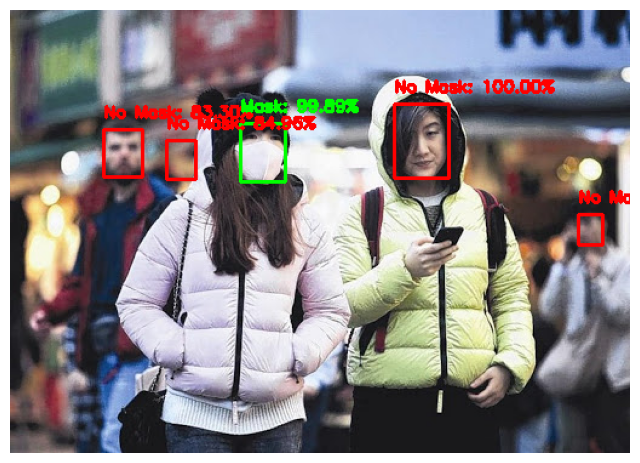

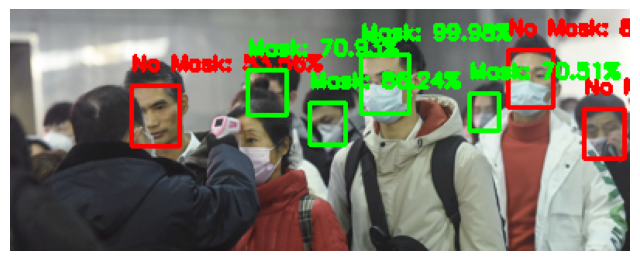

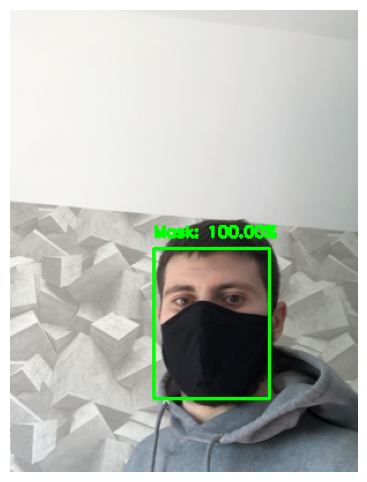

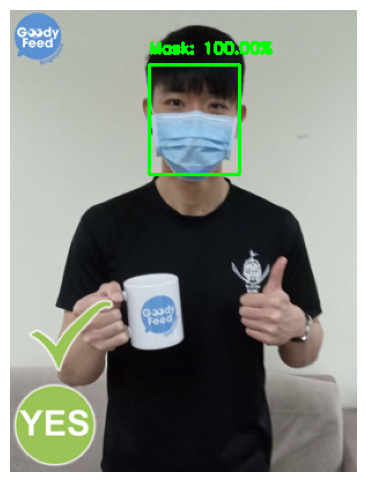

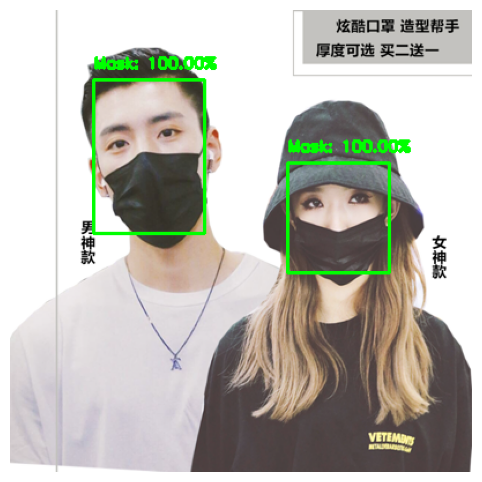

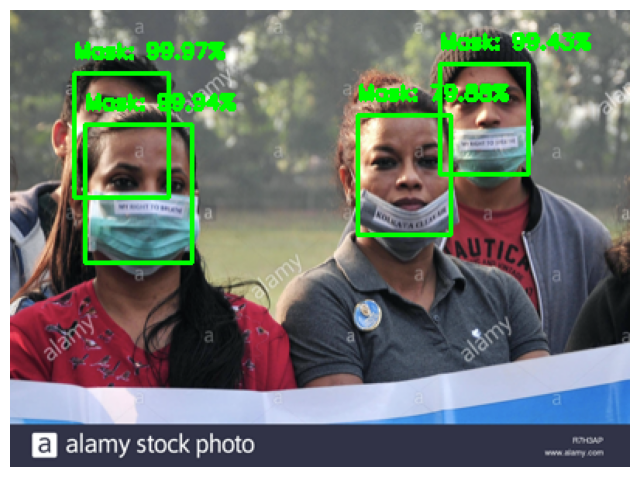

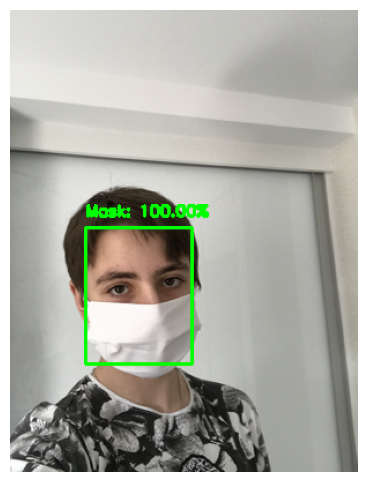

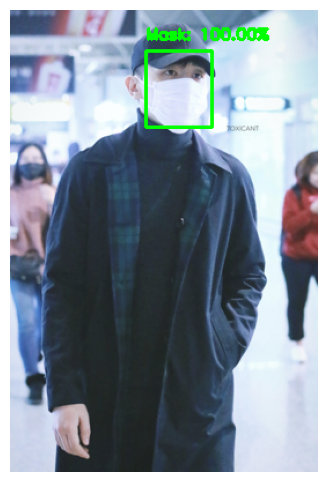

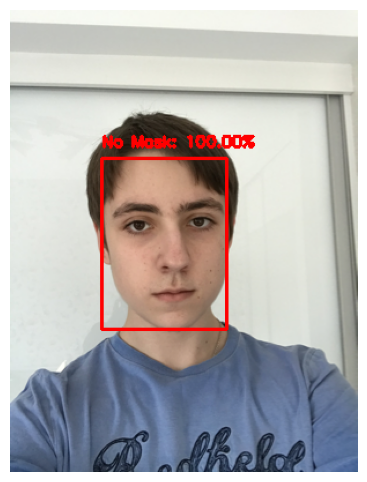

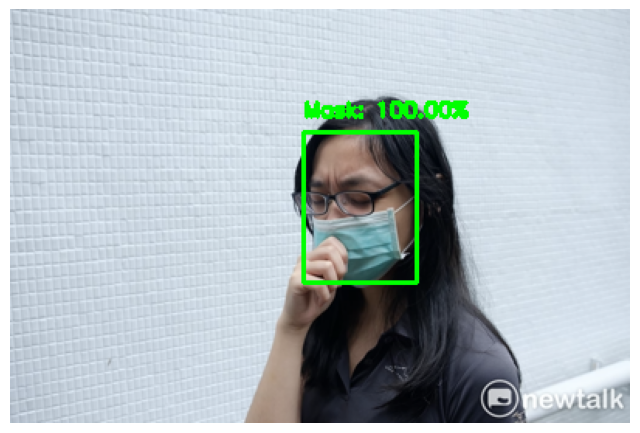

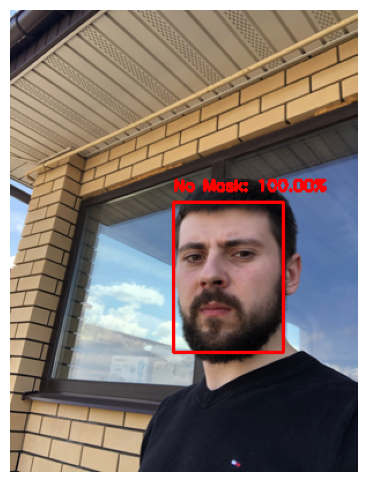

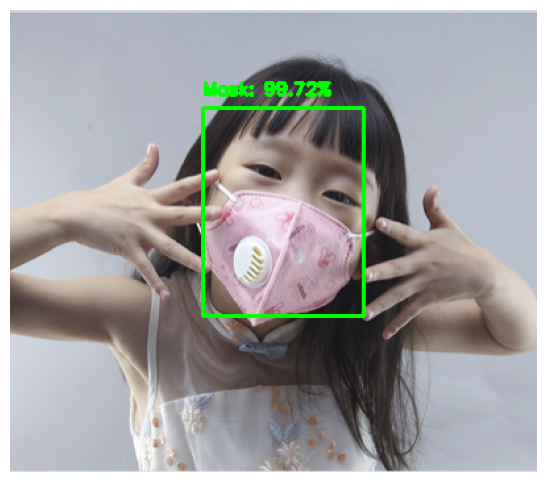

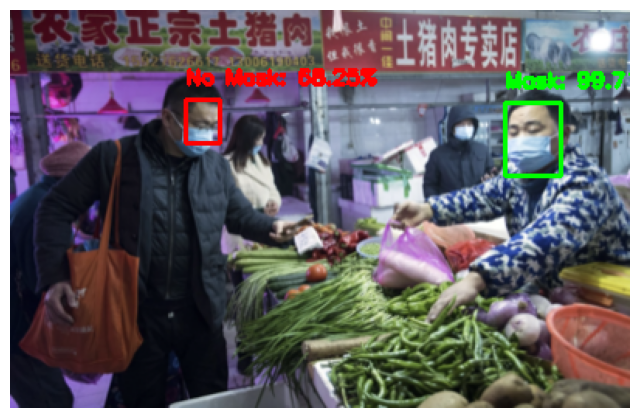

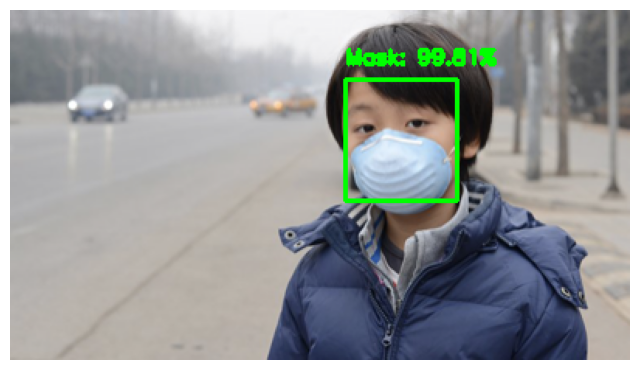

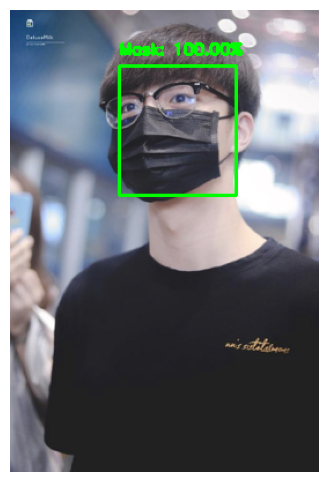

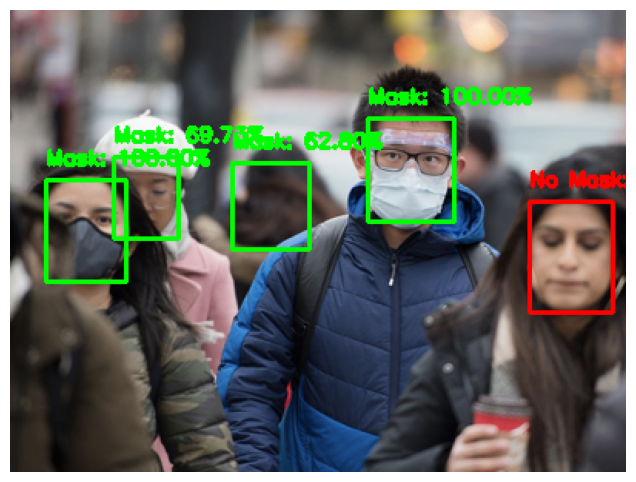

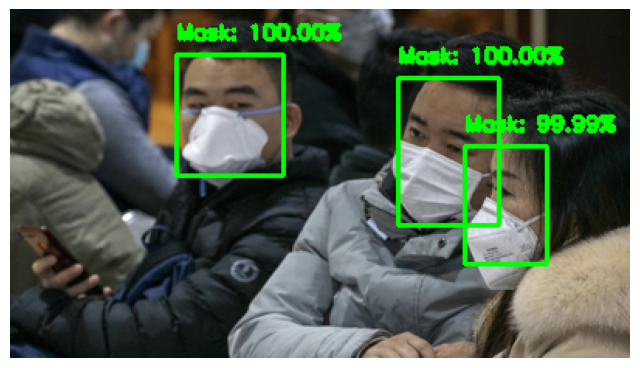

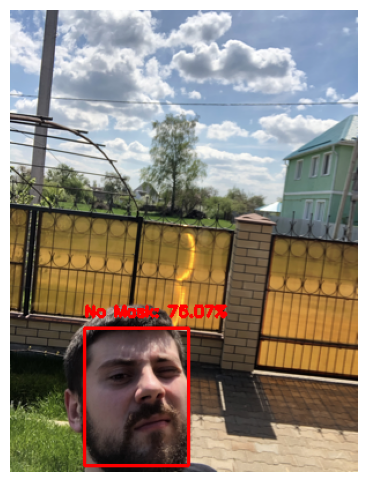

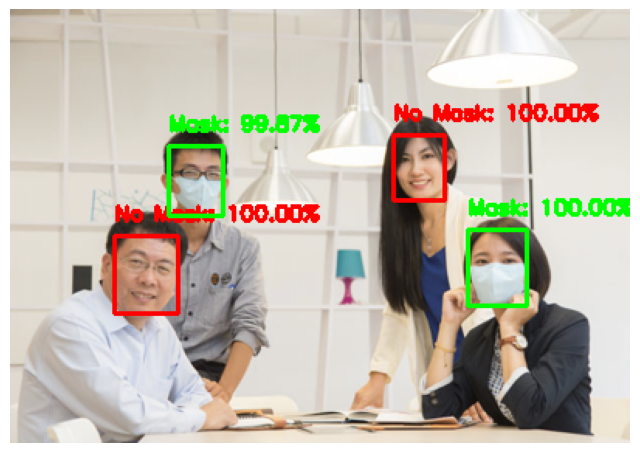

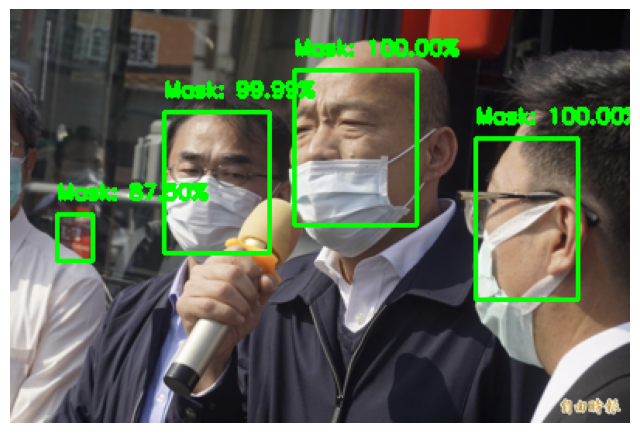


[INFO] Processed 20 images.


In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D
import matplotlib.pyplot as plt

# --------------------------------------------------------
#  Create a custom layer to ignore the 'groups' error
# --------------------------------------------------------
class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(**kwargs)

# --------------------------------------------------------
# Load the model using the custom layer
# --------------------------------------------------------
model_path = "final_best_mask_model.h5"

try:
    print("[INFO] Loading mask classifier...")
    mask_classifier = load_model(model_path, custom_objects={'DepthwiseConv2D': FixedDepthwiseConv2D})
    print("[INFO] Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --------------------------------------------------------
# Face Detection Pipeline
# --------------------------------------------------------
images_folder = "good"
output_folder = "mask_detection"
os.makedirs(output_folder, exist_ok=True)

face_detector = cv2.FaceDetectorYN_create(
    model=r"C:\Users\DELL\Downloads\face_detection_yunet_2023mar.onnx",
    config="",
    input_size=(640, 640),
    score_threshold=0.6,
    nms_threshold=0.3,
    top_k=5000
)

processed_count = 0
print(f"[INFO] Processing images from {images_folder}...")

for filename in os.listdir(images_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        if img is None: continue

        h, w = img.shape[:2]
        face_detector.setInputSize((w, h))
        _, faces = face_detector.detect(img)

        if faces is not None:
            for face in faces:
                box = face[:4].astype(int)
                x, y, fw, fh = box

                (startX, startY) = (max(0, x), max(0, y))
                (endX, endY) = (min(w - 1, x + fw), min(h - 1, y + fh))

                face_roi = img[startY:endY, startX:endX]
                if face_roi.shape[0] < 10 or face_roi.shape[1] < 10: continue

                face_blob = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
                face_blob = cv2.resize(face_blob, (224, 224))
                face_blob = np.array(face_blob, dtype="float32") / 255.0
                face_blob = np.expand_dims(face_blob, axis=0)

                preds = mask_classifier.predict(face_blob, verbose=0)[0]
                (mask, withoutMask) = preds

                label = "Mask" if mask > withoutMask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
                prob = max(mask, withoutMask) * 100

                text = f"{label}: {prob:.2f}%"
                cv2.rectangle(img, (x, y), (x + fw, y + fh), color, 2)
                y_text = y - 10 if y - 10 > 10 else y + 10
                cv2.putText(img, text, (x, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, img)
        processed_count += 1

        # عرض الصورة تحت السيل
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

print(f"\n[INFO] Processed {processed_count} images.")


## Mask Detection With Camera

In [ ]:
import cv2
import numpy as np
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D

# --------------------------------------------------------
# 1. Keras/TensorFlow Version Compatibility Fix
# --------------------------------------------------------
class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(**kwargs)

# --------------------------------------------------------
# 2. Load Models
# --------------------------------------------------------
print("[INFO] Loading models...")

face_detector = cv2.FaceDetectorYN_create(
    model=r"C:\Users\DELL\Downloads\face_detection_yunet_2023mar.onnx",
    config="",
    input_size=(320, 320), # Initial input size
    score_threshold=0.6,
    nms_threshold=0.3,
    top_k=5000
)


try:
    mask_classifier = load_model("mask_detector.h5", custom_objects={'DepthwiseConv2D': FixedDepthwiseConv2D})
    print("[INFO] Models loaded successfully!")
except Exception as e:
    print(f"[ERROR] Could not load mask model: {e}")
    exit()

# --------------------------------------------------------
# 3. Start Camera Stream
# --------------------------------------------------------
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()


prev_frame_time = 0
new_frame_time = 0

print("[INFO] Starting video stream... Press 'q' to exit.")

while True:
    # Read frame from the camera
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image.")
        break

    # Flip the frame horizontally (Mirror Effect) for a natural view
    frame = cv2.flip(frame, 1)

    # Get frame dimensions
    h, w = frame.shape[:2]
    
    # Update face detector input size to match the camera frame size
    face_detector.setInputSize((w, h))

    # ---------------------------
    # Step 1: Face Detection
    # ---------------------------
    _, faces = face_detector.detect(frame)

    if faces is not None:
        for face in faces:
            # Get face coordinates
            box = face[:4].astype(int)
            x, y, fw, fh = box

            # Ensure coordinates are within image boundaries (Boundary Checks)
            (startX, startY) = (max(0, x), max(0, y))
            (endX, endY) = (min(w - 1, x + fw), min(h - 1, y + fh))

            # Crop the face region
            face_roi = frame[startY:endY, startX:endX]

            # Ignore very small faces (noise)
            if face_roi.shape[0] < 20 or face_roi.shape[1] < 20:
                continue

            # ---------------------------
            # Step 2: Mask Classification
            # ---------------------------
            # Pre-process the face image for the model
            face_blob = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
            face_blob = cv2.resize(face_blob, (224, 224))
            face_blob = np.array(face_blob, dtype="float32") / 255.0
            face_blob = np.expand_dims(face_blob, axis=0)

            # Predict
            preds = mask_classifier.predict(face_blob, verbose=0)[0]
            (mask, withoutMask) = preds

            # Determine label and color
            if mask > withoutMask:
                label = "Mask"
                color = (0, 255, 0) # Green
                prob = mask * 100
            else:
                label = "No Mask"
                color = (0, 0, 255) # Red
                prob = withoutMask * 100

            # ---------------------------
            # Step 3: Draw and Display
            # ---------------------------
            text = f"{label}: {prob:.1f}%"
            
            # Draw bounding box
            cv2.rectangle(frame, (x, y), (x + fw, y + fh), color, 2)
            
            # Display text (handle top edge cases)
            y_text = y - 10 if y - 10 > 10 else y + 10
            cv2.putText(frame, text, (x, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # ---------------------------
    # Calculate and Display FPS
    # ---------------------------
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f"FPS: {int(fps)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    # Show the final frame
    cv2.imshow("Real-Time Face Mask Detector", frame)

    # Exit loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup and close windows
cap.release()
cv2.destroyAllWindows()